# Imports

In [1]:
import shutil
import os
import copy
import matplotlib.pyplot as plt

from molgroups.support import molstat
from molgroups.infotheory import entropy

print(os.getcwd())

RunOptimization = False

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_sequential_execution/refl1d


# Create Short Example Fit

A functional fit needs to be provided loading simX.dat data files. Currently, the information theory package requires all parameters to be defined using the Parameter() method, and names should not contain spaces. Solvent nSLDs need to be named rho_solv_X to allow the correct background scattering to be calculated.

In [2]:
%%writefile ssblm.py
## === Import section ===
import sys
# append path to your molgroups, or just link molgroups to your same directory
import numpy as np
from molgroups import mol
from molgroups import lipids
from molgroups import components as cmp
from refl1d.names import load4, Parameter, SLD, Slab, Stack, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, l_submembrane, l_lipid1, l_lipid2, vf_bilayer):
    """ Fairly generic bilayer. This assumes a stack of materials already existing because siox.l is set to zero """
    
    # Set unused parameters
    l_siox = 0.0 # could make a parameter in the future
    rho_siox = 0.0

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, rho_siox=rho_siox, l_siox=l_siox,
              l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
    
    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # Return nSLD profile in Refl1D units
    return nsld*1e6

### Define bilayer parameters
vf_bilayer = Parameter(name='volume_fraction_bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner_acyl_chain_thickness', value=10.0).range(8, 16)
l_lipid2 = Parameter(name='outer_acyl_chain_thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer_roughness', value=5).range(2, 9)
global_rough = Parameter(name ='tiox_roughness', value=5).range(2, 9)
l_tiox = Parameter(name='total_tiox_thickness', value=120).range(50, 150)
l_submembrane = Parameter(name='submembrane_thickness', value=10).range(0, 50)

### Define bilayer object
blm = mol.ssBLM(lipids=[lipids.DOPC], lipid_nf=[1.0])

### Define molgroups space.
dimension=300       # Number of steps
stepsize=0.5        # Length of steps

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
tiox = SLD(name='tiox', rho=2.1630, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_tiox = Slab(material=tiox, thickness=l_tiox - (blm.substrate.z + 0.5 * blm.substrate.l), interface=0.0)
layer_siox = Slab(material=siox, thickness=7.5804, interface=10.000)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=0.0000)

## Set sample parameter ranges and constraints between layer properties
# layer roughness parameters
###################################################################
## the 'interface' associated with layer0 is the boundary between #
## layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
layer_siox.interface = siox_interface = Parameter(name='siox_interface', value=5.0).range(2.0000, 9.000)

# Si and SiOx roughnesses are the same
layer_silicon.interface = layer_siox.interface

# nSLD parameters
d2o.rho = rho_d2o = Parameter(name='rho_solv_0', value=6.34).range(5.3000, 6.5000)
h2o.rho = rho_h2o = Parameter(name='rho_solv_1', value=-0.56).range(-0.6, 0.6)
tiox.rho = rho_tiox = Parameter(name='rho_tiox', value=2).range(1.1630, 3.1630)
siox.rho = rho_siox = Parameter(name='rho_siox', value=3.5).range(3.1000, 5.1000)

# layer thickness parameters
layer_tiox.thickness = tiox_thickness = Parameter(name='tiox_thickness', value=100.).range(66.379, 266.38)
layer_siox.thickness = siox_thickness = Parameter(name='siox_thickness', value=30.).range(5, 40)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=d2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)
mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=h2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_tiox | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_tiox | mollayerh | layer_h2o

## === Data files ===
probe = load4('sim0.dat', back_reflectivity=True)
probeh = load4('sim1.dat', back_reflectivity=True)

# Set instrumental (probe) parameters
probe.background = background_0 = Parameter(name='background_0', value=0.).range(-1e-7, 1e-5)
probeh.background = background_1 = Parameter(name='background_1', value=0.).range(-1e-7, 1e-5)
probe.intensity = intensity = Parameter(name='intensity', value=1.0).range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset = theta_offset = Parameter(name='theta_offset', value=0.).range(-0.015, 0.005)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening = sample_broadening = Parameter(name='sample_broadening', value=0).range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
# probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe.

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)

problem = FitProblem([model, modelh])

## === Export objects for post analysis ===
problem.name = "DOPC bilayer on TiOx substrate"
problem.bilayers = [blm]
problem.dimension = dimension
problem.stepsize = stepsize


Overwriting ssblm.py


# steps: 50, # draws: 9000
step 1 cost 84.667(84)
                            background_0 |......... 3.13238e-07 in (-1e-07,1e-05)
                               intensity ........|.    1.03062 in (0.9,1.05)
                       sample_broadening |......... -0.00453784 in (-0.005,0.02)
                            theta_offset .....|.... -0.00333692 in (-0.015,0.005)
                          siox_interface ......|...    6.42681 in (2,9)
                                rho_siox ....|.....    4.06852 in (3.1,5.1)
                          siox_thickness ...|......    18.0364 in (5,40)
                                rho_tiox ....|.....    2.11176 in (1.163,3.163)
                          tiox_thickness |.........     83.465 in (66.379,266.38)
                              rho_solv_0 ...|......    5.68315 in (5.3,6.5)
                          tiox_roughness .........|    8.65245 in (2,9)
              inner_acyl_chain_thickness .......|..    14.3543 in (8,16)
              outer_acyl

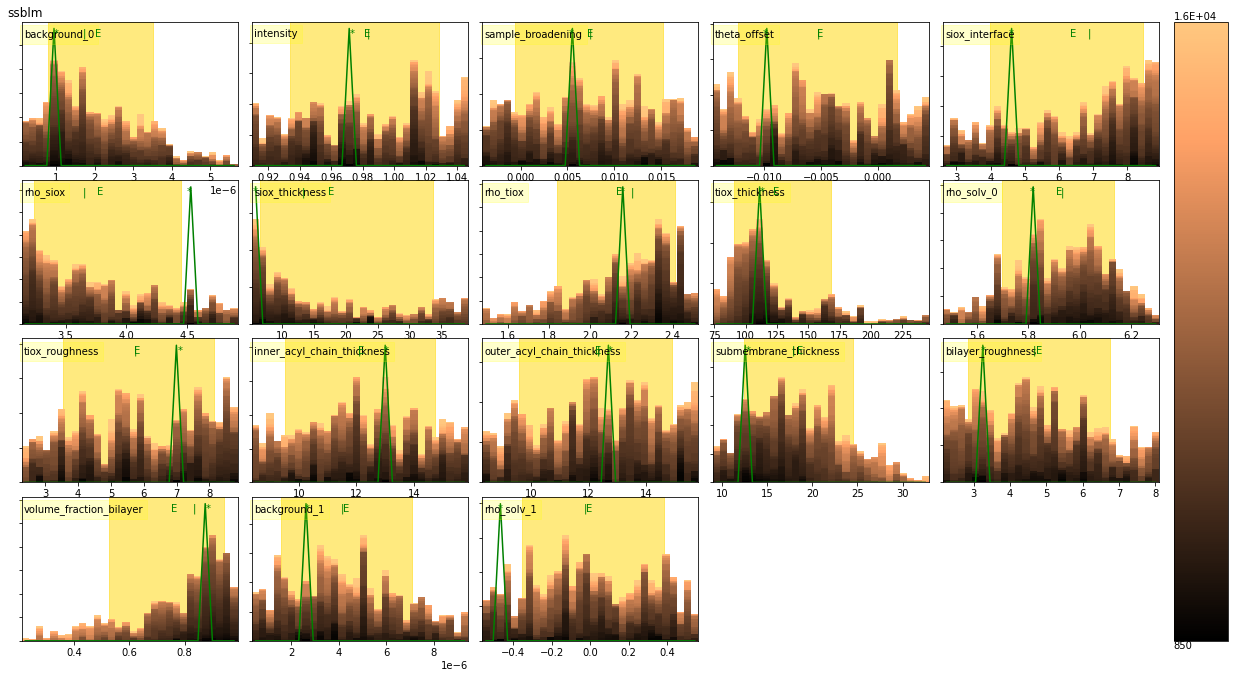

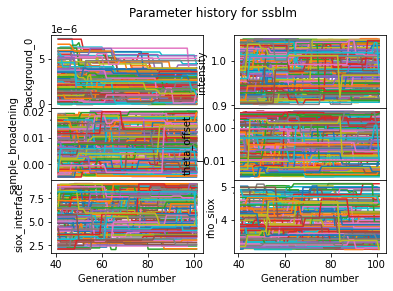

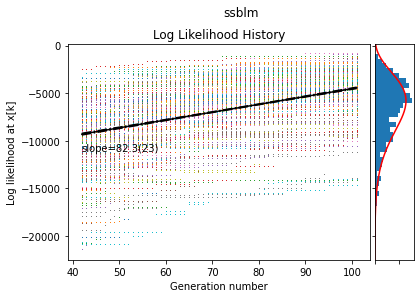

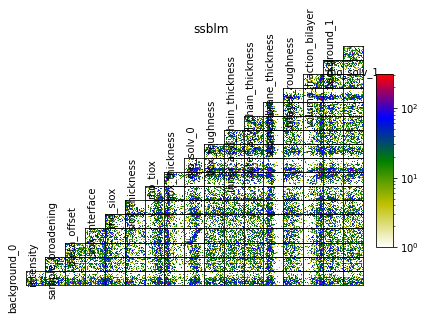

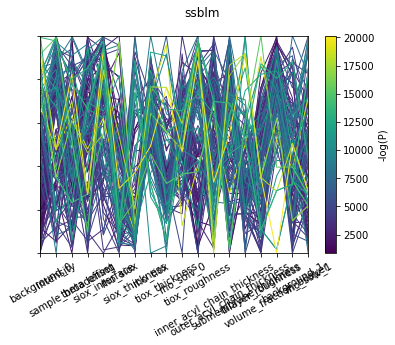

<Figure size 432x288 with 0 Axes>

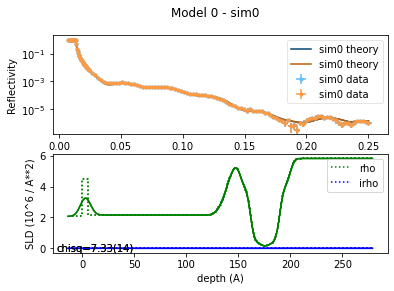

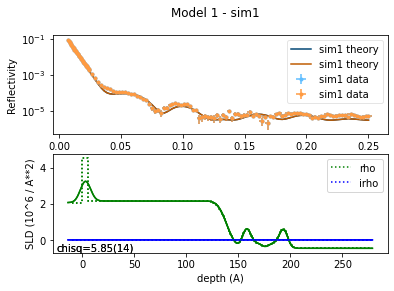

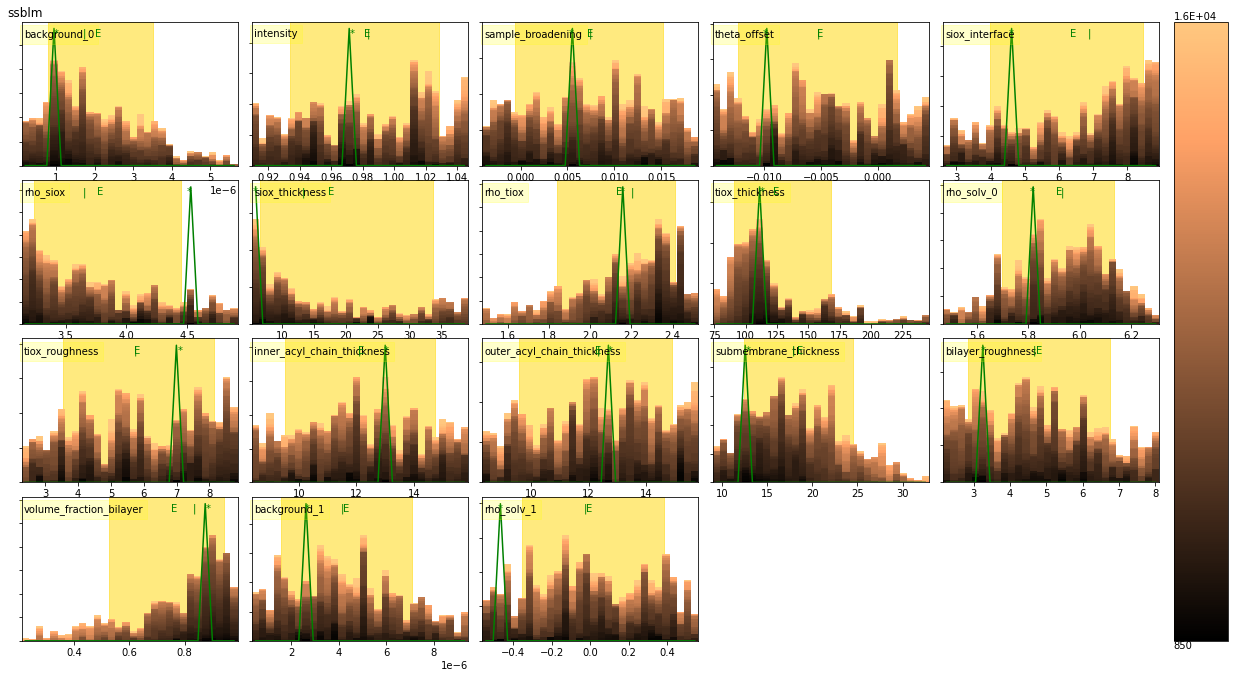

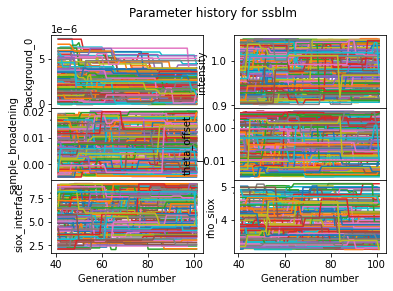

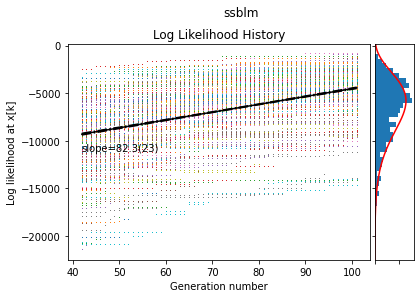

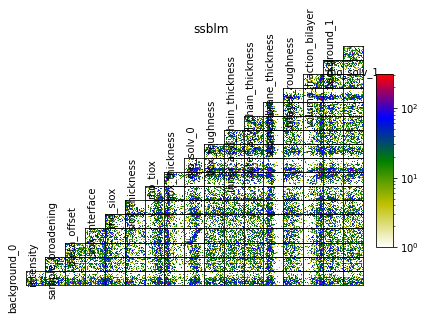

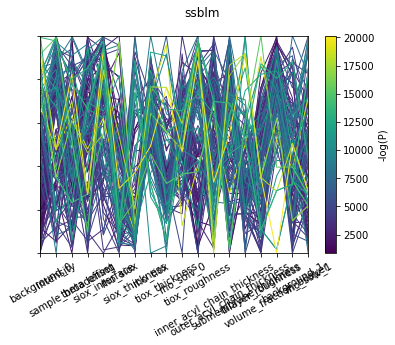

In [3]:
shutil.copyfile('ch060.refl', 'sim1.dat')
shutil.copyfile('ch061.refl', 'sim0.dat')

setupdir = os.getcwd()
store = "T"
runfile = "ssblm"
fitsource = "refl1d"
if not os.path.isdir(store):
    os.mkdir(store)
burn = 50
steps = 50

fit_object = molstat.CMolStat(fitsource=fitsource, spath=setupdir, mcmcpath=store, runfile=runfile, state=None, problem=None)
fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

# Single Dataset Simulation

In [4]:
text = [
    'background_0 1.03489e-06',
    'intensity 1.0',
    'sample_broadening 0',
    'theta_offset 0.0',
    'siox_interface 6.85069',
    'rho_siox 3.39556',
    'siox_thickness 14.9832',
    'rho_tiox 2.32129',
    'tiox_thickness 110.913',
    'tiox_roughness 6.8149',
    'inner_acyl_chain_thickness 11.1605',
    'outer_acyl_chain_thickness 13.6487',
    'submembrane_thickness 13.9116',
    'bilayer_roughness 4.84472',
    'volume_fraction_bilayer 0.906858',
    'rho_solv_0 6.21572',
    'background_1 3.95582e-06',
    'rho_solv_1 -0.550133'
    ]

f=open('simpar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

Reflectometry data simulation currently supports only one configuration for all datasets. This is historical, but can be easily changed in the code. Changing qmin and qmax is currently not supported due to complications with the 4 column file metadata.

In [5]:
configuration_dataset1 = [{'prefactor': 1.000}]

configuration = [configuration_dataset1]
fit_object.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=None, qmax=None, qrangefromfile=True, t_total=None)

                           par       value
0                 background_0    0.000001
1                    intensity    1.000000
2            sample_broadening    0.000000
3                 theta_offset    0.000000
4               siox_interface    6.850690
5                     rho_siox    3.395560
6               siox_thickness   14.983200
7                     rho_tiox    2.321290
8               tiox_thickness  110.913000
9               tiox_roughness    6.814900
10  inner_acyl_chain_thickness   11.160500
11  outer_acyl_chain_thickness   13.648700
12       submembrane_thickness   13.911600
13           bilayer_roughness    4.844720
14     volume_fraction_bilayer    0.906858
15                  rho_solv_0    6.215720
16                background_1    0.000004
17                  rho_solv_1   -0.550133
[[{'prefactor': 1.0}]]


## Compare original and simulated data.

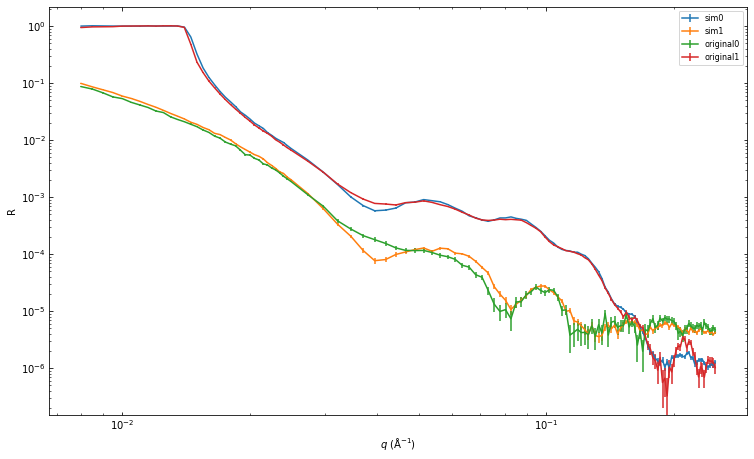

In [6]:
import pandas

fig, ax = plt.subplots()

original0 = pandas.read_csv('ch060.refl', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])
simdata0 = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])
original1 = pandas.read_csv('ch061.refl', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])
simdata1 = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])

ax.errorbar(simdata0['Q'], simdata0['R'], simdata0['dR'], label="sim0")
ax.errorbar(simdata1['Q'], simdata1['R'], simdata1['dR'], label="sim1")
ax.errorbar(original0['Q'], original0['R'], original0['dR'], label="original0")
ax.errorbar(original1['Q'], original1['R'], original1['dR'], label="original1")

ax.legend(fontsize=8)
ax.set_ylabel("R", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(1e-2, 1e8)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


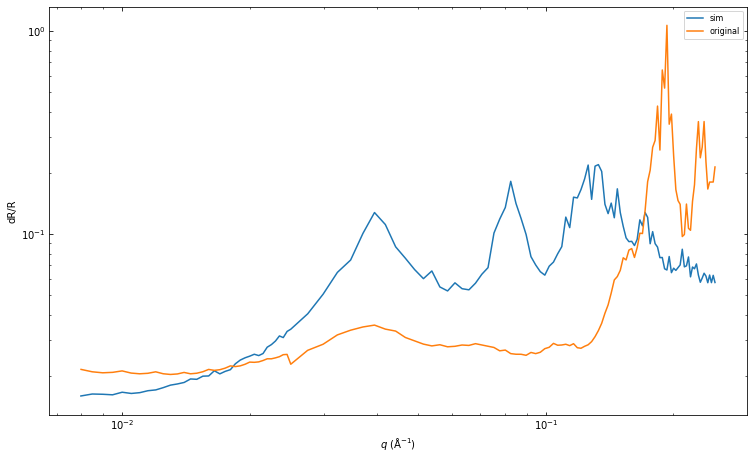

In [7]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('ch061.refl', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])
simdata = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#', names=['Q', 'R', 'dR', 'dQ'])

ax.plot(simdata['Q'], (simdata['dR']/simdata['R']), label="sim")
ax.plot(original['Q'], (original['dR']/original['R']), label="original")

ax.legend(fontsize=8)
ax.set_ylabel("dR/R", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(0, 0.25)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()

# Experimental Optimization

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries.
* Configuration parameters are given by a preceeding n x y, where x is the data set it applies to and y the configuration number. Specifying x,y = '*' makes this parameter apply to all configurations.
* Any numbers x y following a fit parameter indicates that this paramter is used for this particular dataset/configuration to determine the background (incoherent crosssection). This typically applies to SLDs. The 'mode' argument for entropy.Entropy() then determines whether this is to be interpreted as an aqueous solvent or other. Sometimes, instead of subtracting an incoherent crosssection from the data, a background parameter is retained in the model. If any of the parameters is asigned an x = bi, this background will be se to the incoherent (isotropic) crosssection of the ith data set, instead of applying this value to the configuration. Fit boundaries for such backgrounds must be large enough to encompass all possible outcomes. They will not be updated dynamically.
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step).
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* Any theta offset currently needs to have an initial value of zero. Otherwise, refl1d will shift the q-values during data simulation with unexpected outcomes.
* If an instrumental parameter is specified for one data set, the instrumental parameter needs to be specified for all other datasets, as well.
* Data filenames are currently limited to sim.dat for a single file fit, or simx.dat, x = 0 ... n, for fits with multiple data sets

In [8]:
text = [
    'i _ _ background_0 1.03489e-06 -1e-07 1e-05',
    'i _ _ intensity 1.0 0.9 1.05',
    'i _ _ sample_broadening 0 -0.005 0.02',
    'i _ _ theta_offset 0.0 -0.015 0.005',
    'i _ _ siox_interface 6.85069 2 9',
    'i _ _ rho_siox 3.39556 3.1 5.1',
    'i _ _ siox_thickness 14.9832 5 40',
    'i _ _ rho_tiox 2.32129 1.163 3.163 -1 10 1',
    'i _ _ tiox_thickness 110.913 66.379 266.38',
    'i _ _ tiox_roughness 6.8149 2 9',
    'd _ _ inner_acyl_chain_thickness 11.1605 8 16',
    'd _ _ outer_acyl_chain_thickness 13.6487 8 16',
    'd _ _ submembrane_thickness 13.9116 0 50',
    'd _ _ bilayer_roughness 4.84472 2 9',
    'd _ _ volume_fraction_bilayer 0.906858 0 1',
    'i _ _ rho_solv_0 6.21572 5.3 6.5',
    'i _ _ background_1 3.95582e-06 -1e-07 1e-05',
    'i _ _ rho_solv_1 -0.550133 -0.6 0.6',
    'n * * prefactor 1.0'
    ]

f=open('entropypar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

# Variables

In [9]:
# general fit setup
setupdir = os.getcwd()
runfile = "ssblm"
store = 'T'
fitsource = "refl1d"

# particular entropy setup
burn = 8000
steps = 500
convergence = 2.0
miniter = 1
mode = 'water'
bClusterMode = False
bFetchMode = False
time = 2
bcalcsymmetric = True
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = []
script.append('#!/bin/bash\n')
script.append('#SBATCH --job-name=entro {mcmc_iteration}\n')
script.append('#SBATCH -A mc4s9np\n')
script.append('#SBATCH -p RM\n')
script.append('#SBATCH -t 0' + str(time) + ':00:00\n')
script.append('#SBATCH -N 4\n')
script.append('#SBATCH --ntasks-per-node 28\n')
script.append('\n')
script.append('set +x\n')
script.append('cd $SLURM_SUBMIT_DIR\n')
# script.append('cd '+dirname+'\n')
script.append('\n')
script.append('module load python/2.7.11_gcc\n')
script.append('export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n')
script.append('\n')
script.append('mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time=' 
              + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn) 
              + ' --steps=' + str(steps) + '\n')


# Fit Setup

In [10]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn, 
    mcmcsteps=steps, 
    convergence=convergence, 
    miniter=miniter, 
    mode=mode,                      
    bClusterMode=bClusterMode, 
    bFetchMode=bFetchMode, 
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel, 
    plotlimits_filename=plotlimits_filename,
    slurmscript=script
)

In [11]:
if RunOptimization:
    entr.run_optimization(qrangefromfile=True)

In [12]:
entr.plot_results()